In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import itertools 
import scipy
import matplotlib
import glob
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse
import scipy.io as sio
import matplotlib.mlab as mlab

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
length_list = [0, 248956422, 491149951, 689445510, 879660065, 1061198324,
               1232004303, 1391350276, 1536488912, 1674883629, 1808681051,
               1943767673, 2077042982, 2191407310, 2298451028, 2400442217,
               2490780562, 2574038003, 2654411288, 2713028904, 2777473071,
               2824183054, 2875001522, 3031042417]

chr_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20',
             '21', '22', 'X', 'Y']

v2_FILE = '/project/GCRB/Hon_lab/shared/former_members/s160875/03.analysis/Mosaic-seq/CROP-DE-analysis_10X-66K_no_downsampling-CPM.hg38/\
combine_10sgRNAs-volcano/generate_annotations/plot_annotation.txt'

annot_df = pd.read_csv(v2_FILE,
        header = None,
        sep='\t',
        names = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 'chr_idx'])

In [3]:
def outlier_plot(ax, fc_list, plot_x_val, plot_y_val, outlier_idx, plot_idx, color):
    outlier_fc = np.array([])
    outlier_y_val = np.array([])
    outlier_x_val = np.array([])
        
    idx = np.intersect1d(plot_idx, outlier_idx)
    for j in idx:
        if fc_list[j] > 1:
            outlier_fc = np.append(outlier_fc, get_fc_range(fc_list[j]))
        else:
            outlier_fc = np.append(outlier_fc, get_fc_range(1/fc_list[j]))
            
        outlier_x_val = np.append(outlier_x_val, plot_x_val[j])
        outlier_y_val = np.append(outlier_y_val, plot_y_val[j])
        
    ax.scatter(outlier_x_val, outlier_y_val,
               color=color,
               s=outlier_fc,
               marker='o',
               edgecolor='w')

def get_fc_range(val):
    if (val >= 4):
        fc_range = 200
    elif (val >= 2):
        fc_range = 100
    else:
        fc_range = 50
    return fc_range

## Load data
___

In [22]:
DATA_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB361/'
global_gene_df = pd.read_csv(DATA_DIR + 'MB361_global_hit.csv')

In [23]:
plot_gene_idx = np.load('/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/MB361-GWAS+SM/rand_cell/MB361-5perc_expre_gene_idx.npy')

In [24]:
express_df = global_gene_df[(global_gene_df['idx'].isin(plot_gene_idx)) \
                                 &((global_gene_df['fc_by_rand_dist_cpm'] > 1.2) | (global_gene_df['fc_by_rand_dist_cpm'] < 0.8))\
                                 &(global_gene_df['padj-Gaussian'] < -50)\
                                 &(global_gene_df['num_cell'] > 500)
                                 ]

In [25]:
print(express_df.shape)

(9875, 15)


## Volcano plot
___

In [28]:
DIR = '/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/MB361-GWAS+SM/jupyter_plots/'

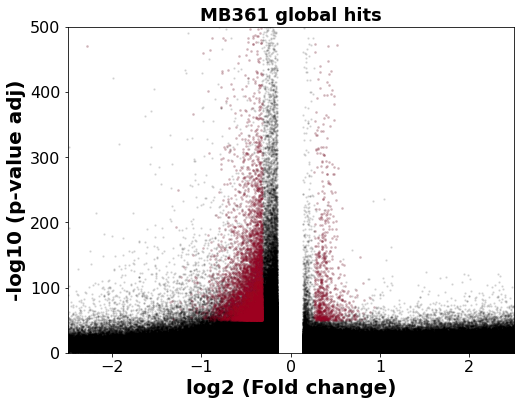

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
#ax.set_facecolor('#E9E9E9')
#ax.grid(linestyle = '--')
ax.scatter(np.log2(global_gene_df['fc_by_rand_dist_cpm']),
          -global_gene_df['padj-Gaussian'],
          s=2,
          color='#000000',
          alpha=0.1)

ax.scatter(np.log2(express_df['fc_by_rand_dist_cpm']),
          -express_df['padj-Gaussian'],
          s=4,
          color='#A60628',
          alpha=0.1)

#label title and axises
ax.set_title('MB361 global hits',
         fontsize=18, fontweight='bold')
ax.set_xlim([-2.5,2.5])
ax.set_ylim([0,500])
ax.set_xlabel('log2 (Fold change)', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16, color='#000000')
ax.set_ylabel('-log10 (p-value adj)', fontsize=20, fontweight='bold')
plt.yticks(fontsize=16, color='#000000')
#plt.show()
plt.savefig(DIR + 'MB361_local_hit_volcano-250_hits-v3.tiff')

## Calculation for stats table in paper
___

In [7]:
local_df_columns = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 'chr_idx', 
                    'region', 'distance', 'num_cell', 'bin', 'pval', 'fc', 
                    'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [8]:
local_df = pd.read_csv('./MB361-filter_local_df.csv')[local_df_columns]

In [12]:
local_df.shape

(366, 15)

In [28]:
# for each test region, median # of local hits
collections.Counter(local_df['region']).values()

dict_values([1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [29]:
np.median([1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

1.0

In [30]:
# for each gene hit, median # of local region 
collections.Counter(local_df['gene_names']).values()

dict_values([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [31]:
np.median([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

1.0

### global

In [4]:
global_df_columns = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 
                     'chr_idx', 'region', 'num_cell', 'bin', 'pval', 'fc', 
                     'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [5]:
global_df = pd.read_csv('./MB361-expressed_global_hit.csv')[global_df_columns]

In [6]:
global_df.shape

(9875, 14)

In [14]:
len(set(global_df['gene_names'].values))

3897

In [33]:
np.median([2, 2, 10, 5, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 4, 2, 1, 3, 2, 1, 3, 1, 1, 4, 1, 1, 2, 4, 1, 1, 2, 1, 4, 3, 5, 1, 2, 3, 2, 4, 4, 6, 2, 1, 2, 1, 27, 2, 1, 1, 4, 6, 1, 5, 1, 2, 2, 2, 1, 1, 1, 2, 4, 1, 1, 4, 1, 1, 1, 3, 3, 1, 2, 3, 2, 2, 1, 3, 1, 1, 2, 1, 1, 2, 1, 2, 2, 3, 3, 1, 3, 1, 4, 1, 1, 1, 2, 3, 7, 4, 3, 3, 2, 16, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 7, 2, 2, 1, 3, 2, 2, 2, 3, 1, 2, 1, 1, 1, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 3, 4, 5, 1, 4, 1, 1, 3, 1, 1, 2, 3, 2, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 6, 5, 6, 2, 5, 4, 3, 7, 2, 8, 7, 1, 9, 4, 1, 2, 4, 4, 9, 7, 8, 4, 4, 9, 5, 4, 5, 5, 9, 4, 2, 14, 3, 4, 8, 3, 2, 3, 7, 2, 3, 2, 6, 9, 3, 4, 12, 3, 4, 5, 2, 3, 17, 6, 10, 1, 7, 8, 2, 1, 5, 7, 11, 5, 3, 4, 8, 2, 7, 4, 8, 3, 14, 6, 4, 7, 2, 6, 2, 3, 2, 2, 2, 11, 2, 9, 5, 12, 3, 3, 1, 10, 5, 10, 3, 2, 3, 4, 1, 4, 5, 4, 1, 4, 10, 4, 2, 4, 3, 5, 4, 8, 2, 8, 3, 11, 3, 3, 3, 4, 2, 4, 7, 9, 7, 6, 2, 3, 1, 5, 8, 14, 1, 6, 13, 10, 5, 4, 11, 8, 4, 2, 4, 2, 3, 4, 5, 12, 8, 11, 1, 4, 5, 8, 1, 2, 2, 7, 6, 10, 2, 2, 5, 3, 4, 5, 1, 4, 1, 3, 4, 2, 1, 1, 1, 1, 1, 3, 2, 2, 2, 2, 1, 1, 7, 2, 1, 1, 1, 1, 2, 3, 6, 2, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 5, 2, 1, 1, 2, 1, 2, 2, 3, 1, 8, 1, 2, 2, 1, 1, 3, 2, 1, 3, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1, 2, 1, 3, 4, 2, 3, 1, 2, 3, 2, 5, 1, 2, 1, 2, 2, 2, 1, 4, 7, 2, 2, 1, 2, 2, 4, 5, 1, 6, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 6, 2, 1, 1, 4, 2, 4, 3, 3, 1, 1, 2, 2, 1, 1, 2, 3, 3, 3, 1, 2, 1, 1, 2, 4, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 4, 2, 1, 1, 1, 1, 1, 4, 1, 3, 1, 1, 3, 4, 5, 2, 1, 2, 2, 1, 1, 2, 1, 5, 2, 1, 2, 5, 1, 4, 2, 2, 3, 1, 1, 1, 2, 6, 1, 2, 2, 2, 1, 3, 1, 1, 2, 5, 2, 1, 4, 2, 2, 1, 1, 4, 7, 4, 1, 1, 1, 3, 2, 5, 2, 5, 1, 2, 2, 1, 14, 3, 1, 6, 5, 1, 2, 8, 1, 9, 14, 1, 6, 9, 2, 4, 3, 9, 9, 4, 3, 2, 10, 6, 3, 5, 7, 3, 7, 6, 2, 6, 5, 3, 4, 8, 4, 3, 5, 2, 3, 1, 7, 6, 5, 2, 2, 11, 4, 1, 5, 2, 13, 8, 4, 4, 3, 2, 4, 4, 2, 4, 6, 3, 6, 20, 2, 6, 3, 11, 6, 2, 7, 3, 3, 4, 3, 3, 6, 17, 7, 5, 3, 6, 7, 8, 4, 4, 4, 3, 6, 6, 2, 2, 6, 8, 5, 4, 3, 6, 8, 1, 3, 3, 1, 3, 4, 11, 6, 2, 2, 5, 4, 11, 7, 3, 12, 18, 4, 3, 6, 10, 6, 10, 5, 8, 9, 8, 6, 2, 4, 6, 1, 7, 5, 3, 6, 10, 5, 2, 7, 2, 3, 1, 3, 2, 2, 7, 4, 5, 2, 3, 4, 6, 7, 1, 3, 6, 2, 5, 5, 4, 5, 2, 10, 1, 2, 1, 4, 5, 5, 1, 9, 2, 1, 10, 3, 2, 4, 3, 8, 7, 6, 3, 6, 1, 3, 8, 3, 1, 6, 2, 7, 6, 3, 2, 3, 11, 4, 10, 6, 3, 4, 3, 10, 6, 6, 4, 8, 4, 3, 8, 6, 7, 7, 5, 1, 3, 4, 15, 2, 1, 5, 8, 1, 6, 5, 6, 6, 9, 10, 3, 6, 5, 4, 5, 4, 2, 3, 5, 2, 2, 3, 5, 6, 7, 3, 8, 3, 8, 6, 8, 5, 5, 2, 3, 11, 6, 1, 13, 5, 2, 4, 5, 6, 2, 4, 1, 3, 5, 5, 5, 14, 3, 11, 1, 4, 3, 1, 3, 6, 7, 3, 7, 4, 1, 5, 6, 4, 4, 2, 3, 5, 4, 4, 3, 6, 5, 5, 2, 8, 13, 3, 4, 7, 4, 2, 2, 5, 3, 4, 1, 5, 2, 10, 5, 2, 2, 2, 7, 6, 4, 8, 1, 4, 4, 3, 17, 9, 8, 4, 4, 3, 5, 2, 16, 2, 5, 6, 18, 3, 11, 3, 3, 4, 6, 10, 3, 5, 3, 2, 8, 4, 4, 2, 7, 4, 6, 1, 3, 3, 3, 4, 4, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 6, 4, 3, 1, 3, 2, 3, 1, 1, 2, 3, 3, 1, 1, 1, 2, 1, 3, 1, 1, 4, 4, 6, 1, 6, 1, 2, 1, 3, 1, 1, 2, 4, 5, 1, 3, 1, 2, 1, 1, 4, 1, 3, 2, 2, 2, 2, 3, 1, 5, 4, 2, 2, 3, 1, 3, 6, 1, 2, 3, 1, 3, 6, 2, 1, 4, 1, 1, 4, 3, 7, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 3, 3, 2, 2, 3, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 6, 1, 1, 1, 2, 3, 1, 1, 2, 1, 1, 2, 1, 3, 4, 3, 1, 3, 1, 1, 1, 1, 5, 1, 3, 1, 1, 5, 5, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 3, 1, 2, 2, 2, 1, 1, 4, 1, 2, 2, 1, 2, 3, 1, 3, 2, 1, 1, 1, 3, 1, 3, 8, 1, 1, 1, 4, 2, 3, 1, 1, 1, 1, 2, 1, 2, 2, 1, 3, 1, 2, 2, 2, 7, 2, 1, 3, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 2, 2, 1, 1, 3, 3, 1, 7, 3, 7, 2, 2, 1, 1, 1, 2, 5, 6, 4, 1, 1, 1, 2, 2, 1, 2, 1, 2, 5, 1, 1, 1, 1, 1, 2, 3, 4, 1, 3, 5, 1, 1, 1, 1, 5, 1, 3, 1, 3, 4, 1, 2, 1, 2, 1, 1, 5, 1, 1, 3, 1, 1, 4, 6, 8, 5, 2, 7, 4, 2, 7, 4, 3, 5, 7, 3, 3, 5, 3, 3, 9, 7, 2, 4, 7, 1, 4, 5, 1, 5, 3, 2, 11, 4, 7, 5, 6, 18, 1, 4, 8, 7, 6, 5, 4, 3, 1, 4, 1, 7, 6, 5, 5, 2, 3, 11, 3, 1, 2, 11, 3, 8, 5, 11, 3, 5, 7, 4, 4, 5, 4, 6, 3, 10, 5, 4, 12, 9, 6, 4, 8, 4, 5, 6, 5, 4, 3, 4, 5, 2, 8, 1, 5, 4, 1, 5, 13, 3, 4, 1, 3, 3, 7, 6, 2, 8, 9, 7, 3, 2, 6, 5, 5, 12, 4, 3, 3, 2, 3, 12, 10, 4, 4, 2, 9, 2, 2, 2, 11, 1, 4, 3, 3, 5, 5, 4, 3, 8, 14, 4, 6, 2, 2, 9, 5, 4, 7, 8, 1, 8, 3, 4, 4, 2, 2, 8, 3, 5, 7, 1, 3, 1, 7, 5, 8, 11, 2, 6, 7, 9, 2, 6, 2, 10, 6, 6, 4, 4, 10, 5, 5, 1, 5, 4, 6, 3, 1, 11, 5, 10, 7, 11, 8, 7, 10, 6, 3, 4, 4, 4, 1, 3, 5, 2, 8, 14, 3, 5, 3, 1, 2, 2, 4, 7, 5, 2, 6, 3, 3, 3, 7, 5, 11, 9, 12, 3, 4, 10, 2, 6, 7, 7, 10, 5, 4, 6, 3, 3, 5, 2, 3, 1, 1, 1, 1, 1, 1, 5, 1, 2, 2, 1, 1, 3, 2, 2, 5, 4, 2, 1, 1, 3, 2, 1, 1, 1, 1, 3, 1, 4, 2, 1, 1, 5, 2, 2, 2, 1, 1, 3, 1, 2, 2, 2, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 5, 1, 1, 1, 1, 3, 4, 2, 1, 1, 3, 1, 2, 1, 1, 1, 3, 1, 3, 3, 1, 2, 4, 1, 4, 4, 8, 2, 3, 5, 4, 5, 3, 2, 5, 5, 4, 2, 2, 3, 5, 6, 3, 5, 1, 8, 3, 5, 3, 5, 4, 5, 3, 12, 6, 2, 3, 9, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3, 2, 3, 1, 3, 1, 1, 2, 5, 2, 2, 3, 1, 1, 1, 1, 2, 3, 1, 3, 1, 1, 2, 2, 1, 1, 3, 2, 1, 2, 2, 3, 3, 1, 3, 1, 1, 4, 1, 2, 4, 1, 5, 1, 2, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 5, 5, 3, 2, 4, 1, 2, 3, 3, 1, 2, 2, 1, 5, 2, 2, 1, 2, 3, 1, 2, 1, 7, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 2, 3, 1, 2, 10, 3, 13, 3, 6, 5, 2, 3, 4, 3, 2, 4, 6, 5, 14, 5, 5, 4, 10, 4, 4, 4, 6, 9, 6, 4, 2, 6, 2, 2, 19, 7, 6, 10, 6, 4, 5, 9, 6, 6, 6, 6, 2, 7, 1, 7, 8, 13, 1, 3, 5, 11, 7, 7, 4, 6, 1, 5, 1, 5, 2, 2, 2, 1, 1, 1, 3, 1, 3, 1, 2, 1, 2, 2, 1, 2, 3, 1, 3, 1, 2, 3, 4, 4, 2, 1, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 4, 1, 3, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 9, 1, 1, 7, 1, 1, 1, 1, 3, 2, 1, 2, 2, 2, 1, 1, 1, 1, 4, 1, 3, 1, 1, 1, 2, 3, 1, 2, 2, 1, 2, 2, 2, 3, 1, 3, 1, 1, 4, 1, 1, 1, 3, 3, 1, 2, 1, 3, 1, 1, 6, 2, 1, 3, 5, 3, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1, 2, 2, 1, 3, 3, 3, 2, 3, 1, 5, 1, 2, 3, 1, 1, 2, 1, 3, 2, 1, 2, 1, 1, 1, 1, 4, 2, 3, 9, 6, 1, 5, 8, 2, 10, 3, 1, 7, 2, 3, 4, 2, 3, 5, 13, 5, 4, 9, 4, 4, 5, 3, 9, 3, 12, 9, 2, 6, 3, 4, 7, 3, 4, 7, 4, 2, 8, 7, 3, 16, 3, 3, 5, 4, 5, 4, 10, 3, 4, 6, 3, 4, 6, 12, 3, 2, 1, 2, 5, 2, 5, 6, 5, 4, 5, 1, 4, 5, 9, 9, 8, 4, 1, 11, 2, 5, 1, 6, 12, 4, 4, 3, 13, 2, 3, 2, 2, 4, 2, 1, 1, 5, 3, 7, 7, 5, 2, 3, 6, 5, 5, 2, 5, 7, 2, 7, 1, 3, 5, 2, 5, 8, 2, 8, 9, 4, 7, 2, 5, 5, 1, 4, 9, 11, 5, 6, 3, 4, 1, 5, 4, 13, 6, 4, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 6, 2, 2, 1, 1, 1, 6, 1, 2, 3, 2, 2, 1, 2, 2, 2, 3, 1, 1, 1, 4, 2, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 5, 1, 2, 2, 4, 1, 1, 2, 1, 1, 2, 3, 2, 1, 3, 1, 2, 2, 5, 3, 3, 3, 5, 4, 3, 1, 1, 2, 1, 2, 2, 2, 1, 3, 3, 2, 1, 1, 2, 1, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 1, 4, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 7, 1, 2, 1, 3, 2, 2, 3, 1, 3, 5, 1, 2, 2, 1, 2, 2, 2, 1, 2, 3, 1, 4, 4, 1, 1, 1, 1, 2, 3, 2, 3, 1, 1, 1, 1, 3, 3, 1, 1, 2, 3, 1, 3, 1, 1, 1, 2, 4, 1, 1, 5, 3, 2, 3, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 2, 7, 3, 2, 2, 2, 2, 2, 1, 3, 1, 4, 2, 2, 3, 3, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 3, 3, 2, 1, 1, 1, 1, 3, 1, 1, 1, 5, 2, 5, 1, 1, 1, 2, 1, 4, 1, 2, 2, 4, 1, 1, 2, 1, 2, 1, 3, 1, 6, 1, 1, 3, 3, 1, 2, 2, 6, 12, 8, 5, 1, 11, 6, 3, 19, 5, 7, 4, 2, 8, 1, 3, 8, 1, 6, 4, 14, 7, 2, 12, 6, 3, 6, 9, 5, 4, 3, 5, 2, 5, 6, 3, 10, 4, 4, 7, 3, 14, 15, 3, 3, 2, 1, 8, 4, 5, 3, 4, 4, 4, 1, 6, 5, 2, 4, 6, 10, 4, 2, 10, 7, 3, 7, 7, 4, 7, 5, 13, 3, 5, 3, 6, 4, 2, 4, 6, 3, 12, 7, 1, 2, 6, 2, 3, 15, 3, 4, 1, 6, 3, 2, 12, 7, 6, 11, 3, 2, 5, 4, 10, 10, 1, 2, 5, 3, 10, 3, 1, 4, 4, 9, 4, 1, 7, 6, 5, 10, 4, 8, 1, 5, 6, 5, 2, 4, 4, 3, 3, 9, 5, 4, 6, 12, 4, 1, 1, 11, 3, 3, 3, 12, 4, 3, 9, 12, 5, 4, 7, 5, 23, 6, 3, 3, 2, 2, 3, 1, 4, 6, 11, 7, 2, 3, 6, 3, 8, 14, 6, 16, 3, 3, 1, 9, 5, 7, 5, 7, 2, 6, 5, 4, 2, 6, 13, 1, 7, 2, 7, 6, 4, 1, 2, 5, 6, 4, 7, 14, 5, 4, 3, 3, 6, 7, 4, 5, 4, 7, 1, 2, 4, 3, 6, 2, 7, 1, 7, 4, 4, 3, 10, 4, 9, 1, 1, 4, 1, 7, 1, 3, 4, 3, 10, 5, 5, 3, 5, 2, 10, 2, 2, 5, 5, 4, 4, 8, 9, 3, 3, 4, 5, 1, 16, 26, 3, 10, 5, 3, 7, 4, 5, 8, 2, 1, 8, 5, 5, 1, 1, 4, 1, 6, 3, 4, 6, 2, 3, 1, 4, 2, 7, 2, 1, 2, 7, 7, 3, 2, 4, 6, 6, 2, 3, 4, 3, 3, 2, 2, 1, 3, 1, 1, 1, 6, 1, 1, 3, 1, 2, 1, 3, 1, 3, 1, 2, 3, 2, 3, 1, 1, 1, 3, 3, 2, 2, 2, 3, 3, 1, 1, 1, 1, 2, 1, 1, 7, 2, 1, 2, 1, 1, 2, 1, 2, 4, 1, 1, 1, 5, 4, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 3, 1, 1, 3, 4, 5, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 3, 1, 1, 1, 6, 4, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 3, 1, 3, 2, 1, 1, 5, 4, 4, 1, 2, 7, 2, 5, 8, 2, 2, 1, 5, 1, 7, 4, 3, 19, 6, 4, 1, 4, 6, 2, 2, 5, 4, 2, 1, 4, 8, 4, 4, 1, 7, 8, 3, 2, 3, 3, 3, 1, 3, 7, 2, 2, 6, 2, 1, 7, 3, 8, 1, 1, 8, 3, 5, 9, 2, 6, 4, 2, 5, 16, 1, 2, 2, 9, 2, 4, 4, 4, 6, 10, 3, 5, 1, 10, 5, 3, 1, 1, 3, 1, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 3, 3, 1, 6, 2, 4, 4, 10, 4, 5, 4, 3, 2, 1, 6, 3, 3, 2, 3, 7, 6, 5, 7, 4, 8])

3.0

In [35]:
np.median([1, 1, 3, 13, 2, 1, 2, 4, 5, 1, 2, 4, 5, 2, 2, 1, 1, 2, 3, 2, 2, 5, 137, 2, 9, 5, 1, 1, 2, 3, 1, 1, 3, 1, 2, 2, 1, 4, 8, 3, 9, 2, 1, 3, 12, 2, 2, 1, 1, 1, 1, 2, 5, 1, 2, 2, 1, 26, 3, 1, 4, 2, 4, 1, 2, 2, 1, 9, 3, 4, 2, 3, 8, 7, 2, 1, 15, 1, 1, 1, 3, 4, 1, 3, 1, 3, 4, 2, 5, 5, 3, 3, 1, 1, 2, 2, 2, 3, 2, 3, 1, 4, 3, 33, 5, 3, 2, 8, 8, 7, 1, 2, 3, 5, 1, 2, 3, 2, 9, 5, 1, 4, 3, 2, 6, 2, 5, 1, 2, 6, 5, 1, 3, 1, 3, 1, 9, 1, 3, 2, 1, 1, 6, 3, 1, 1, 3, 4, 3, 28, 3, 3, 7, 3, 1, 1, 2, 1, 2, 4, 2, 2, 1, 2, 2, 1, 4, 2, 2, 1, 1, 8, 9, 3, 1, 2, 1, 2, 6, 3, 1, 1, 2, 5, 2, 8, 5, 4, 3, 7, 1, 6, 5, 5, 3, 2, 1, 11, 4, 1, 2, 5, 1, 4, 2, 9, 1, 1, 1, 2, 5, 1, 3, 1, 1, 2, 3, 3, 5, 5, 8, 2, 4, 6, 4, 2, 1, 1, 4, 2, 3, 1, 3, 1, 1, 2, 3, 1, 4, 3, 2, 1, 2, 11, 8, 1, 5, 1, 1, 6, 3, 2, 1, 6, 1, 1, 1, 1, 2, 1, 2, 1, 4, 3, 2, 3, 4, 2, 6, 1, 3, 6, 8, 1, 2, 1, 1, 1, 1, 6, 1, 1, 4, 4, 6, 1, 3, 1, 1, 2, 1, 1, 4, 2, 1, 1, 3, 8, 3, 4, 3, 1, 2, 1, 2, 2, 2, 3, 1, 3, 1, 9, 3, 2, 1, 2, 1, 2, 4, 3, 4, 2, 5, 3, 5, 2, 3, 3, 4, 1, 1, 2, 6, 3, 2, 1, 5, 4, 1, 3, 1, 8, 2, 1, 1, 3, 6, 1, 448, 1, 2, 3, 5, 10, 4, 2, 3, 2, 4, 2, 1, 4, 5, 3, 2, 1, 5, 1, 1, 1, 1, 1, 1, 3, 5, 7, 1, 3, 1, 35, 1, 2, 1, 3, 5, 1, 4, 2, 3, 2, 50, 3, 2, 3, 3, 2, 2, 3, 3, 1, 15, 1, 10, 1, 3, 6, 5, 5, 8, 1, 5, 5, 2, 3, 1, 4, 1, 3, 8, 1, 3, 4, 4, 7, 4, 3, 1, 6, 3, 3, 6, 1, 1, 1, 3, 5, 4, 6, 4, 4, 4, 5, 1, 3, 10, 3, 10, 1, 2, 6, 3, 1, 4, 1, 7, 4, 4, 2, 3, 7, 2, 3, 3, 3, 1, 2, 12, 9, 1, 3, 10, 6, 7, 6, 1, 4, 8, 1, 9, 6, 2, 1, 3, 2, 5, 1, 5, 1, 3, 1, 2, 17, 16, 2, 10, 1, 1, 5, 3, 10, 3, 1, 2, 5, 2, 3, 1, 5, 2, 1, 1, 5, 3, 4, 1, 3, 4, 1, 4, 4, 2, 1, 6, 3, 7, 5, 3, 2, 1, 10, 8, 8, 3, 4, 1, 11, 4, 9, 2, 13, 2, 3, 6, 1, 4, 4, 5, 1, 1, 2, 2, 4, 8, 2, 4, 1, 4, 4, 2, 1, 1, 3, 5, 1, 3, 1, 2, 2, 3, 3, 3, 3, 1, 5, 2, 5, 5, 3, 20, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, 4, 3, 2, 4, 3, 1, 1, 5, 6, 7, 6, 4, 1, 2, 3, 8, 3, 9, 4, 9, 1, 6, 5, 1, 2, 1, 2, 1, 3, 3, 2, 2, 1, 4, 3, 2, 3, 3, 6, 7, 3, 2, 7, 1, 1, 4, 2, 1, 1, 1, 2, 1, 5, 2, 6, 2, 1, 3, 4, 1, 1, 3, 4, 7, 4, 33, 2, 3, 4, 7, 6, 4, 5, 5, 10, 9, 2, 8, 3, 1, 2, 1, 3, 7, 4, 3, 2, 6, 2, 3, 1, 2, 2, 2, 3, 3, 13, 1, 8, 6, 8, 1, 4, 5, 8, 1, 3, 1, 5, 1, 2, 1, 1, 2, 8, 8, 2, 8, 1, 5, 4, 6, 3, 2, 6, 3, 1, 5, 3, 1, 3, 3, 6, 2, 1, 1, 6, 1, 1, 2, 3, 4, 2, 1, 3, 5, 9, 4, 4, 9, 5, 3, 2, 1, 5, 3, 2, 2, 4, 5, 1, 3, 1, 3, 1, 1, 1, 4, 1, 6, 1, 4, 1, 5, 1, 5, 1, 2, 1, 1, 4, 1, 5, 1, 5, 5, 1, 60, 3, 7, 4, 2, 2, 2, 7, 3, 5, 3, 20, 1, 3, 6, 1, 1, 1, 2, 1, 2, 3, 1, 5, 1, 6, 7, 1, 2, 1, 4, 2, 6, 3, 4, 2, 1, 4, 7, 4, 2, 6, 3, 4, 3, 1, 3, 5, 3, 2, 2, 3, 10, 4, 1, 2, 5, 2, 1, 1, 1, 4, 2, 3, 4, 4, 4, 5, 3, 1, 3, 12, 7, 3, 1, 2, 4, 1, 4, 3, 5, 2, 2, 13, 2, 3, 3, 3, 6, 4, 3, 3, 2, 1, 1, 1, 1, 7, 1, 3, 2, 5, 1, 1, 5, 5, 3, 2, 3, 4, 2, 1, 3, 2, 3, 6, 3, 1, 3, 6, 2, 5, 5, 2, 12, 4, 1, 3, 2, 3, 1, 3, 2, 2, 1, 2, 4, 4, 3, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 4, 1, 1, 1, 1, 2, 2, 5, 1, 1, 5, 1, 5, 2, 5, 1, 2, 1, 10, 1, 3, 2, 5, 3, 1, 4, 4, 2, 4, 3, 3, 1, 2, 2, 1, 4, 5, 3, 2, 1, 3, 3, 3, 1, 7, 1, 4, 1, 3, 2, 1, 2, 1, 1, 2, 4, 6, 4, 3, 1, 2, 3, 1, 1, 1, 4, 1, 5, 1, 1, 3, 1, 4, 2, 4, 1, 3, 4, 4, 4, 1, 2, 2, 1, 1, 2, 1, 1, 2, 5, 3, 1, 1, 1, 6, 2, 2, 5, 1, 8, 1, 1, 4, 2, 6, 2, 3, 1, 1, 3, 1, 1, 1, 1, 1, 5, 4, 1, 2, 2, 1, 7, 4, 2, 2, 2, 6, 2, 2, 1, 2, 2, 3, 6, 2, 3, 6, 7, 2, 2, 1, 2, 1, 1, 2, 1, 3, 3, 3, 2, 5, 6, 4, 1, 3, 3, 3, 2, 2, 2, 7, 2, 4, 2, 3, 3, 2, 4, 4, 2, 1, 1, 1, 7, 3, 1, 2, 4, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 3, 2, 1, 5, 1, 3, 3, 1, 1, 2, 3, 6, 4, 4, 3, 5, 1, 1, 1, 2, 1, 2, 1, 3, 5, 5, 3, 2, 2, 2, 4, 1, 4, 5, 4, 1, 9, 4, 1, 1, 2, 1, 1, 2, 3, 1, 5, 2, 4, 5, 3, 6, 1, 2, 6, 1, 1, 2, 2, 5, 5, 4, 2, 1, 2, 1, 1, 1, 6, 3, 1, 2, 3, 2, 3, 3, 2, 5, 3, 1, 1, 4, 3, 2, 1, 1, 4, 1, 1, 1, 4, 3, 3, 1, 10, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 3, 1, 7, 2, 1, 2, 4, 3, 3, 1, 1, 2, 2, 1, 2, 2, 3, 1, 4, 3, 1, 1, 5, 5, 1, 3, 3, 1, 2, 5, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 6, 2, 1, 2, 1, 1, 9, 1, 1, 6, 2, 2, 1, 2, 4, 2, 1, 2, 2, 3, 2, 2, 1, 1, 3, 3, 1, 5, 2, 2, 1, 3, 2, 2, 1, 6, 1, 2, 3, 1, 2, 4, 1, 1, 2, 2, 2, 2, 5, 2, 2, 1, 1, 2, 1, 3, 2, 2, 2, 7, 2, 1, 3, 1, 1, 2, 1, 2, 2, 4, 2, 1, 2, 2, 1, 2, 4, 12, 5, 1, 3, 1, 3, 6, 4, 3, 4, 2, 1, 2, 3, 2, 6, 1, 3, 1, 5, 2, 6, 11, 2, 3, 1, 8, 7, 6, 2, 1, 4, 4, 1, 3, 2, 3, 4, 1, 18, 1, 2, 1, 8, 2, 2, 4, 4, 1, 2, 1, 1, 5, 2, 2, 6, 3, 11, 3, 4, 6, 10, 2, 4, 5, 3, 4, 4, 2, 1, 5, 5, 8, 3, 4, 2, 2, 6, 5, 1, 1, 5, 1, 6, 1, 4, 1, 6, 3, 1, 4, 1, 2, 1, 3, 5, 1, 10, 3, 1, 3, 2, 1, 1, 1, 4, 1, 1, 3, 1, 6, 1, 1, 1, 1, 8, 5, 3, 1, 1, 3, 1, 8, 1, 4, 6, 2, 3, 4, 2, 5, 1, 3, 2, 1, 5, 2, 2, 5, 2, 2, 10, 4, 2, 1, 5, 2, 4, 1, 1, 1, 2, 7, 12, 5, 1, 7, 3, 1, 1, 4, 5, 2, 6, 3, 2, 1, 3, 1, 2, 1, 3, 1, 3, 2, 2, 2, 3, 1, 1, 3, 6, 2, 2, 1, 10, 1, 2, 3, 1, 3, 8, 3, 1, 5, 1, 6, 4, 2, 3, 2, 4, 5, 1, 1, 3, 1, 1, 1, 3, 7, 4, 2, 2, 4, 3, 3, 2, 2, 1, 6, 2, 4, 1, 2, 1, 3, 1, 4, 4, 4, 5, 3, 2, 2, 2, 3, 2, 4, 1, 1, 1, 1, 5, 1, 1, 3, 4, 2, 3, 5, 4, 3, 2, 2, 4, 3, 1, 10, 3, 3, 1, 4, 3, 4, 3, 16, 1, 1, 4, 1, 3, 4, 5, 3, 5, 1, 1, 2, 1, 1, 2, 4, 1, 5, 4, 1, 3, 1, 1, 2, 4, 2, 1, 2, 6, 1, 3, 1, 5, 3, 1, 1, 1, 1, 3, 3, 4, 3, 2, 7, 4, 1, 7, 1, 1, 7, 3, 6, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 4, 2, 4, 4, 1, 3, 2, 2, 1, 2, 2, 1, 1, 1, 3, 1, 1, 2, 2, 4, 4, 1, 1, 1, 2, 2, 1, 4, 4, 3, 3, 2, 1, 6, 2, 2, 3, 1, 1, 2, 8, 2, 1, 1, 1, 7, 2, 1, 1, 2, 3, 1, 3, 1, 4, 1, 3, 1, 6, 2, 4, 5, 5, 5, 3, 2, 3, 2, 9, 3, 1, 3, 7, 2, 4, 6, 6, 7, 3, 1, 7, 3, 4, 1, 2, 2, 1, 2, 2, 3, 4, 1, 3, 2, 4, 1, 1, 2, 2, 1, 3, 8, 5, 1, 6, 6, 2, 5, 2, 1, 3, 2, 6, 1, 1, 1, 4, 2, 1, 3, 2, 5, 1, 3, 1, 1, 4, 3, 3, 2, 4, 1, 1, 2, 2, 2, 4, 5, 1, 2, 5, 1, 8, 1, 1, 2, 1, 2, 2, 5, 1, 2, 2, 3, 1, 3, 1, 1, 2, 2, 6, 1, 1, 2, 1, 1, 2, 1, 5, 1, 2, 4, 2, 6, 5, 2, 3, 2, 1, 1, 4, 6, 3, 1, 2, 1, 3, 2, 4, 2, 2, 1, 1, 6, 1, 3, 1, 4, 4, 1, 5, 3, 2, 5, 2, 2, 4, 3, 1, 1, 4, 3, 1, 2, 1, 4, 1, 1, 1, 4, 3, 1, 1, 3, 5, 1, 1, 1, 1, 5, 4, 1, 2, 3, 1, 1, 3, 1, 1, 3, 3, 3, 4, 4, 2, 4, 1, 1, 1, 3, 2, 2, 2, 1, 2, 2, 3, 3, 3, 1, 2, 1, 3, 2, 3, 2, 2, 2, 8, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 3, 3, 3, 1, 2, 2, 2, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 4, 1, 3, 3, 3, 2, 1, 2, 1, 2, 3, 6, 4, 1, 4, 1, 5, 2, 2, 3, 4, 1, 2, 2, 5, 12, 4, 2, 3, 4, 5, 2, 2, 3, 3, 1, 4, 1, 1, 2, 1, 3, 1, 1, 2, 2, 3, 4, 1, 3, 5, 4, 2, 1, 4, 1, 2, 2, 8, 2, 4, 1, 1, 2, 4, 5, 5, 3, 4, 3, 3, 2, 3, 4, 1, 1, 1, 2, 4, 2, 2, 1, 3, 1, 2, 2, 1, 3, 2, 1, 2, 3, 3, 1, 5, 1, 6, 3, 2, 1, 1, 1, 2, 4, 3, 2, 3, 6, 2, 3, 1, 7, 1, 4, 5, 6, 1, 1, 3, 1, 1, 2, 1, 3, 1, 4, 4, 3, 1, 3, 2, 2, 2, 2, 1, 1, 5, 3, 6, 2, 2, 2, 1, 2, 3, 1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1, 6, 4, 5, 1, 2, 1, 1, 1, 3, 2, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 2, 1, 1, 3, 3, 1, 4, 1, 2, 1, 3, 1, 1, 1, 3, 2, 1, 1, 2, 4, 2, 3, 1, 8, 6, 3, 3, 2, 1, 7, 4, 9, 3, 2, 1, 2, 3, 1, 4, 5, 2, 1, 6, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 2, 1, 1, 1, 5, 1, 3, 1, 1, 2, 1, 1, 2, 3, 3, 2, 1, 1, 6, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 4, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 3, 3, 1, 2, 1, 2, 4, 1, 2, 5, 1, 1, 2, 4, 2, 1, 1, 1, 1, 1, 7, 4, 5, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 5, 1, 1, 1, 1, 3, 1, 2, 1, 4, 3, 2, 3, 4, 1, 1, 2, 2, 1, 2, 1, 5, 4, 2, 2, 3, 2, 2, 3, 3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 2, 3, 1, 3, 4, 4, 4, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 4, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 3, 1, 1, 4, 1, 2, 3, 5, 2, 2, 2, 1, 3, 4, 2, 2, 1, 4, 7, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 4, 2, 3, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 4, 2, 2, 1, 5, 3, 2, 2, 3, 1, 2, 1, 4, 2, 2, 1, 5, 4, 3, 1, 1, 2, 2, 2, 4, 1, 1, 3, 5, 3, 1, 2, 2, 5, 4, 2, 1, 1, 5, 3, 1, 1, 1, 3, 1, 8, 2, 2, 2, 1, 4, 1, 2, 2, 1, 1, 1, 3, 1, 3, 1, 2, 1, 1, 1, 2, 5, 1, 5, 1, 2, 2, 2, 1, 1, 1, 3, 3, 2, 3, 1, 1, 2, 6, 3, 1, 3, 1, 1, 2, 1, 6, 1, 1, 2, 2, 3, 1, 2, 1, 1, 3, 5, 1, 2, 2, 1, 2, 5, 2, 3, 5, 1, 2, 1, 1, 2, 2, 3, 1, 1, 2, 1, 1, 4, 2, 1, 2, 1, 1, 1, 1, 5, 3, 3, 4, 5, 1, 2, 3, 2, 3, 3, 2, 2, 3, 3, 1, 1, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 4, 4, 1, 2, 3, 3, 2, 5, 4, 2, 1, 4, 1, 2, 3, 2, 4, 1, 2, 1, 1, 1, 1, 2, 4, 1, 3, 1, 1, 2, 1, 1, 1, 1, 2, 3, 2, 1, 1, 1, 3, 4, 2, 2, 1, 1, 1, 1, 3, 2, 2, 2, 1, 2, 2, 3, 1, 3, 3, 1, 2, 1, 1, 1, 2, 2, 3, 1, 3, 3, 1, 1, 4, 2, 1, 1, 3, 2, 1, 2, 1, 1, 2, 4, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 3, 1, 1, 6, 1, 1, 2, 3, 1, 2, 2, 3, 1, 1, 3, 5, 1, 2, 3, 5, 1, 2, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 4, 1, 3, 2, 1, 3, 1, 1, 1, 1, 1, 2, 2, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 3, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 3, 1, 1, 1, 3, 2, 1, 2, 5, 2, 2, 1, 1, 1, 6, 4, 5, 1, 1, 2, 2, 1, 2, 1, 1, 1, 6, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 7, 1, 1, 2, 3, 1, 1, 1, 3, 3, 1, 2, 1, 1, 1, 2, 2, 3, 1, 2, 1, 2, 3, 1, 2, 2, 3, 1, 1, 2, 3, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 5, 3, 1, 1, 1, 1, 3, 1, 1, 4, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 4, 1, 3, 1, 2, 2, 2, 2, 4, 4, 2, 1, 7, 1, 1, 1, 2, 1, 2, 4, 1, 2, 1, 1, 2, 4, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1, 4, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 2, 2, 3, 1, 2, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 3, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 1, 4, 2, 1, 3, 1, 1, 2, 1, 1, 4, 3, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 3, 2, 1, 2, 2, 1, 3, 1, 1, 2, 1, 2, 1, 2, 1, 2, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 3, 1, 2, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 2, 3, 4, 1, 1, 4, 1, 2, 1, 4, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 4, 3, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 4, 1, 3, 2, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 5, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 4, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1])

2.0

In [22]:
collections.Counter(global_df['gene_names'].values).most_common()[:20]

[('IFI6', 448),
 ('IFIT1', 137),
 ('CYP1A1', 60),
 ('TRIM16L', 50),
 ('ID3', 35),
 ('CYP1B1', 33),
 ('PHGR1', 33),
 ('IFITM3', 28),
 ('KLF10', 26),
 ('TUBA4A', 20),
 ('FOSB', 20),
 ('DHRS3', 18),
 ('RPP25', 17),
 ('CTPS1', 16),
 ('RP11-443B7.1', 16),
 ('ID1', 15),
 ('ZNF552', 15),
 ('HBQ1', 13),
 ('SNX24', 13),
 ('DUSP23', 13)]

In [15]:
collections.Counter(global_df['region'].values).most_common()[:10]

[('chr16:80614843-80615343', 27),
 ('chr7:45451569-45452069', 26),
 ('chr20:9306394-9306969', 23),
 ('chr1:227319052-227319605', 20),
 ('chr2:201697844-201698403', 19),
 ('chr10:78033481-78034221', 19),
 ('chr13:112905966-112906537', 19),
 ('chr16:3780867-3781867', 18),
 ('chr9:73131878-73132395', 18),
 ('chr1:190633787-190634287', 18)]

## Each region global hits overlap rate
____

In [7]:
region_list = set(global_df['region'])

In [8]:
len(region_list)

2809

In [32]:
overlap_df = pd.DataFrame(data=None, index= region_list, columns=region_list)
for i in region_list:
    genes_i = express_df[express_df['region'] == i]['gene_names'].values
    for j in region_list:
        if i == j:
            overlap_rate = 1
        else:
            genes_j = express_df[express_df['region'] == j]['gene_names'].values
            num_overlap_genes = len(set(genes_i).intersection(set(genes_j)))
            total_num_genes = len(genes_i) + len(genes_j) - num_overlap_genes
            overlap_rate = num_overlap_genes / total_num_genes
        overlap_df.loc[i, j] = overlap_rate

In [33]:
overlap_df.to_csv('./MB361_global_overlap_rate.csv')

In [9]:
overlap_df = pd.DataFrame(data=None, index= region_list, columns=region_list)
for i in region_list:
    genes_i = global_df[global_df['region'] == i]['gene_names'].values
    for j in region_list:
        if i == j:
            num_overlap_genes = len(set(genes_i))
        else:
            genes_j = global_df[global_df['region'] == j]['gene_names'].values
            num_overlap_genes = len(set(genes_i).intersection(set(genes_j)))
        overlap_df.loc[i, j] = num_overlap_genes
        
overlap_df.to_csv('./MB361_global_overlap_num.csv')

### Plotting

In [37]:
overlap_df = pd.read_csv('./MB361_global_overlap_rate.csv', index_col=0)

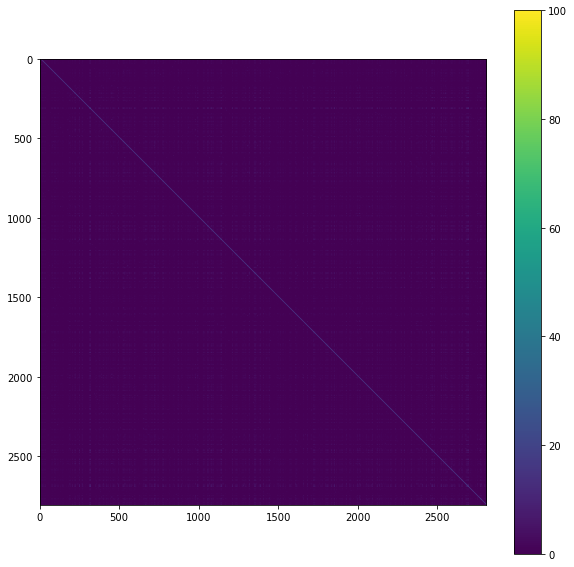

In [38]:
fig, ax = plt.subplots(figsize= (10, 10))

plt.imshow(overlap_df.astype(float)*100, cmap='viridis')
plt.colorbar()

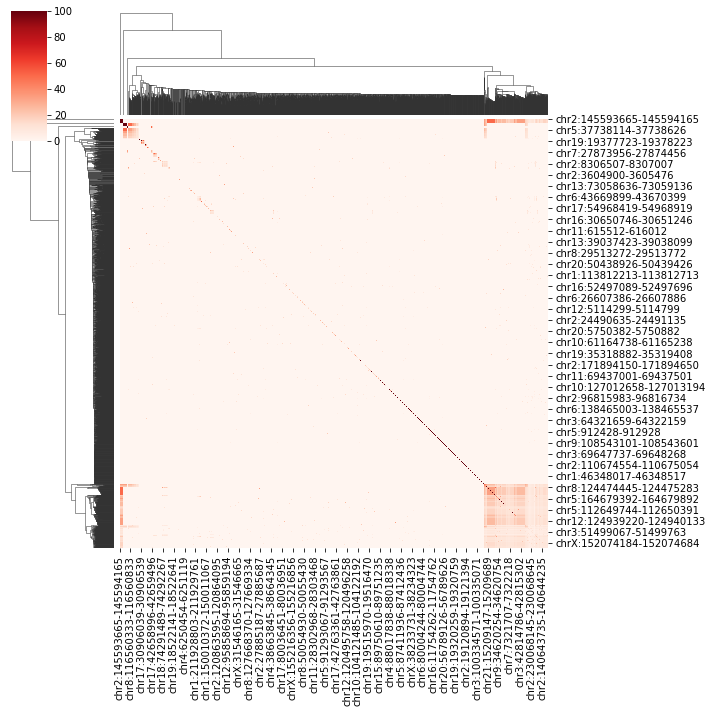

In [40]:
import seaborn as sns 
g = sns.clustermap(overlap_df.astype(float)*100, vmax=100, cmap='Reds')
plt.savefig('./figures/MB361_overlap_rate.png', dpi=600)

### Overlap number

In [4]:
overlap_df = pd.read_csv('./MB361_global_overlap_num.csv', index_col=0)

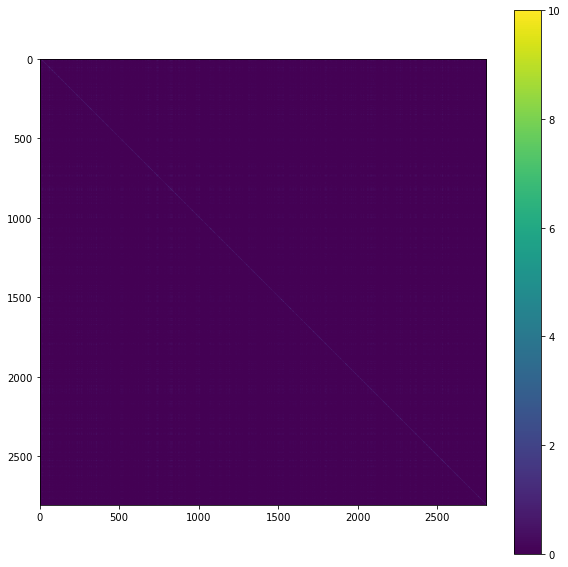

In [5]:
fig, ax = plt.subplots(figsize= (10, 10))

plt.imshow(overlap_df.astype(float), cmap='viridis', vmax=10)
plt.colorbar()

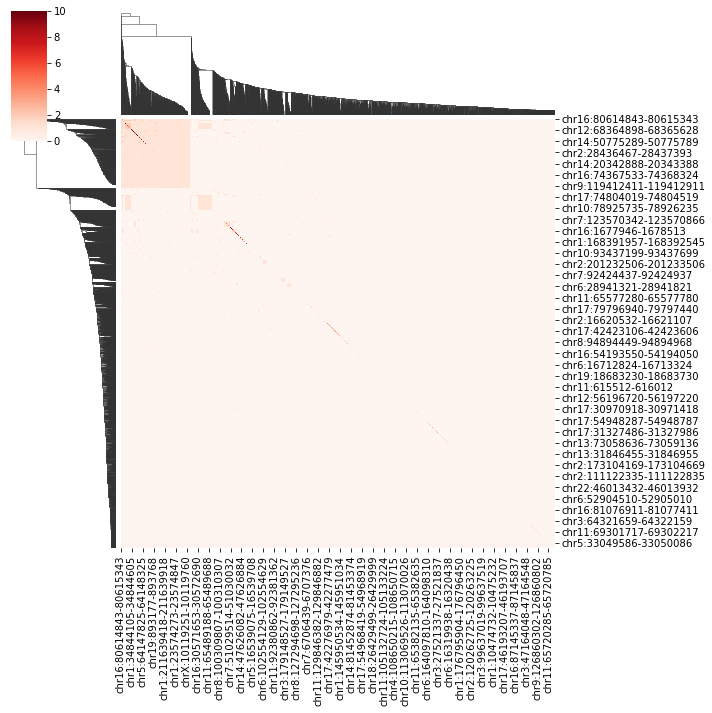

In [7]:
import seaborn as sns 
g = sns.clustermap(overlap_df.astype(float), cmap='Reds', vmax=10)
plt.savefig('./figures/MB361_overlap_num.png', dpi=600)

In [30]:
overlap_df.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_row.reordered_ind]

,chr16:80614843-80615343,chr7:45451569-45452069,chr20:9306394-9306969,chr2:201697844-201698403,chr13:112905966-112906537,chr1:227319052-227319605,chr1:190633787-190634287,chr9:73131878-73132395,chr10:78033481-78034221,chr6:151852310-151852878,...,chr7:101402029-101402529,chr1:201170542-201171042,chr11:65370971-65371471,chr1:153633698-153634232,chr10:21527089-21527589,chr1:121518922-121519422,chr11:695420-695920,chr5:956874-957374,chr9:126860302-126860802,chr12:27844298-27844798
chr16:80614843-80615343,27,1,4,0,3,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
chr7:45451569-45452069,1,26,2,1,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
chr20:9306394-9306969,4,2,23,1,2,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
chr2:201697844-201698403,0,1,1,19,1,2,1,3,1,2,...,0,0,0,0,0,0,0,0,0,0
chr13:112905966-112906537,3,2,2,1,19,2,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr1:121518922-121519422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
chr11:695420-695920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
chr5:956874-957374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
chr9:126860302-126860802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
